<a href="https://colab.research.google.com/github/kkmcgg/experiments/blob/main/kkmc_optimal_transport_image_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://pythonot.github.io/auto_examples/barycenters/plot_debiased_barycenter.html#sphx-glr-auto-examples-barycenters-plot-debiased-barycenter-py


In [ ]:
!pip install -q pot
!pip install -q perlin-noise

In [11]:

import numpy as np
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
from skimage.transform import resize
import ot
from ot.bregman import (
    barycenter,
    barycenter_debiased,
    convolutional_barycenter2d,
    convolutional_barycenter2d_debiased,
)

In [4]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [6]:
shape = (128, 128)
res1 = (8, 8)
res2 = (16, 16)
res3 = (128, 128)
noise = generate_perlin_noise_2d(shape, res1)
noise2 = generate_perlin_noise_2d(shape, res2)


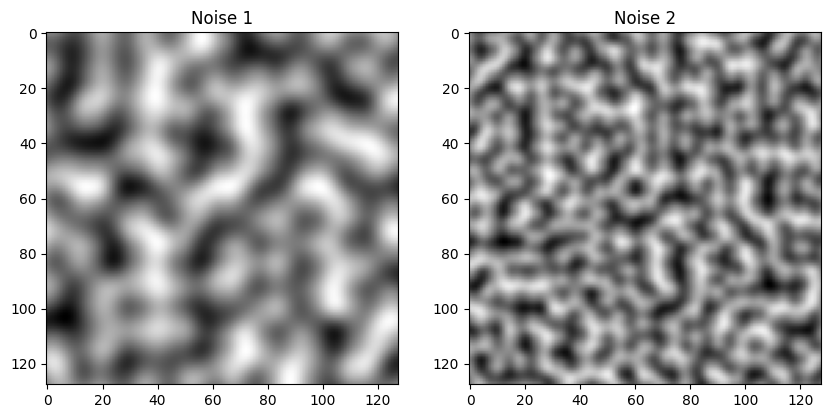

In [7]:
# display noise and noise2
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(noise, cmap='gray')
axes[0].set_title('Noise 1')
axes[1].imshow(noise2, cmap='gray')
axes[1].set_title('Noise 2')
plt.show()

In [8]:
f1= noise - noise.min()
f2= noise2 - noise2.min()

A = np.asarray([f1, f2]) + 1e-2
A /= A.sum(axis=(1, 2))[:, None, None]

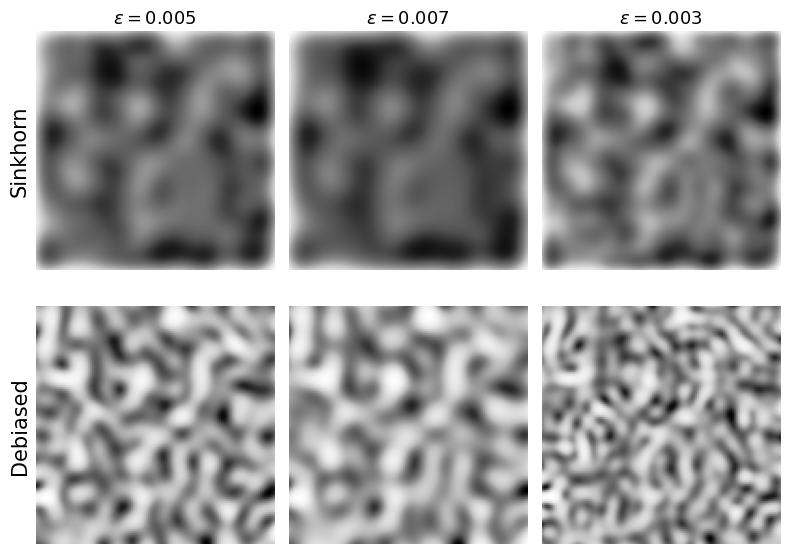

In [12]:
#this is going to do two pot methods of different epsilons
# basically the lower the epsilon the higher the resolution and slower.

bars_sinkhorn, bars_debiased = [], []
epsilons = [5e-3, 7e-3, 3e-3]
for eps in epsilons:
    bar = convolutional_barycenter2d(A, eps)
    bar_debiased, log = convolutional_barycenter2d_debiased(A, eps, log=True)
    bars_sinkhorn.append(bar)
    bars_debiased.append(bar_debiased)

titles = ["Sinkhorn", "Debiased"]
all_bars = [bars_sinkhorn, bars_debiased]
fig, axes = plt.subplots(2, 3, figsize=(8, 6), num=3)
for jj, (method, ax_row, bars) in enumerate(zip(titles, axes, all_bars)):
    for ii, (ax, img, eps) in enumerate(zip(ax_row, bars, epsilons)):
        ax.imshow(img, cmap="Greys")
        if jj == 0:
            ax.set_title(r"$\varepsilon = %.3f$" % eps, fontsize=13)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        if ii == 0:
            ax.set_ylabel(method, fontsize=15)
fig.tight_layout()
plt.show()

In [18]:
def plt_image_row(images, titles=None, figsize=(12, 4)):
  fig, axes = plt.subplots(1, len(images), figsize=figsize)
  for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap="Greys")
    ax.set_title(title)
    ax.axis("off")
  fig.tight_layout()
  plt.show()

In [45]:
def plt_image_annimate(images, titles=None, figsize=(12, 4)):

  from matplotlib.animation import FuncAnimation
  from IPython.display import HTML
  import matplotlib.pyplot as plt

  # --- This block assumes your list `frames` already exists ---

  # 1. Set up the figure
  fig, ax = plt.subplots()
  ax.set_xticks([])
  ax.set_yticks([])

  # 2. Create the image object that will be updated
  im = ax.imshow(images[0], cmap='gray')

  # 3. Function to update the image for each frame
  def update(i):
      im.set_data(images[i])
      return [im]

  # 4. Create and display the animation
  anim = FuncAnimation(fig, update, frames=len(images), interval=60)
  plt.close() # Hide the static plot
  return HTML(anim.to_jshtml())

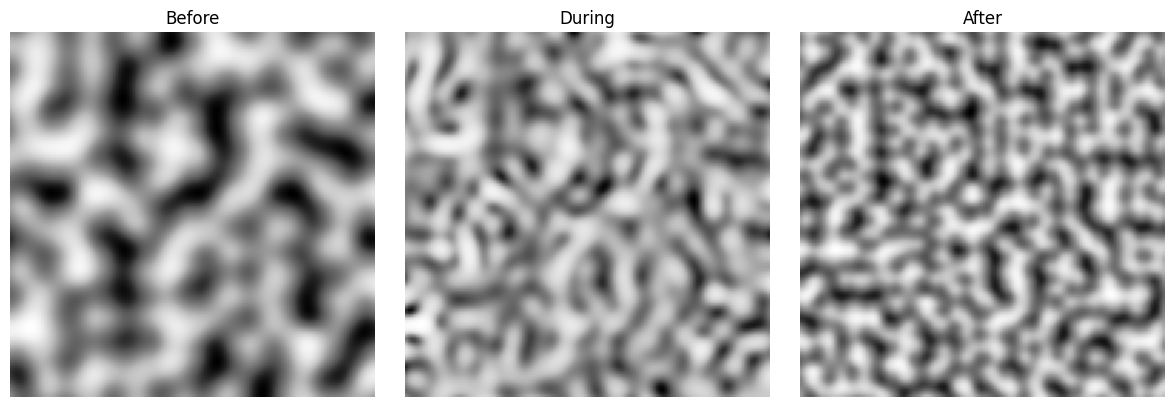

In [19]:
# before, during, after figures

titles = ["Before", "During", "After"]
images = [A[0], bars_debiased[2], A[1]]

plt_image_row(images, titles)


In [50]:
def pot_interpolation(A, eps = 0.05, step=0.1):

  # smooth POT interpolation
  # eps = 0.004
  # eps = 0.05
  # step = 0.1
  timesteps = np.arange(step, 1, step)
  timesteps = np.round(timesteps, 2) # round timeteps
  generated_states = []

  print('generating states...')

  for t in timesteps:
    print(t)
    current_weights = np.array([1 - t, t])
    state, log = ot.bregman.convolutional_barycenter2d_debiased(A, eps, weights=current_weights, log=True)
    generated_states.append(state)

  print("Done.")
  return generated_states, timesteps




In [54]:
eps1 = 0.05
generated_states, timesteps = pot_interpolation(A, eps=eps1)

generating states...
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Done.


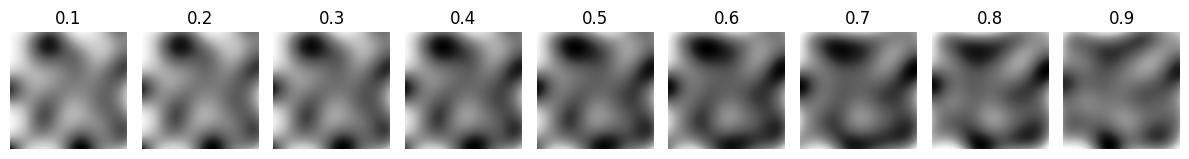

In [55]:
plt_image_row(generated_states, timesteps)

epsilon: 0.05


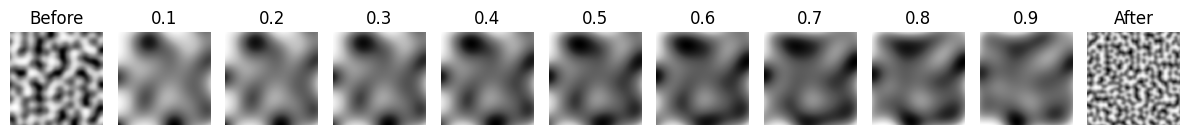

In [56]:
allstates = [A[0], *generated_states, A[1]]
alltitles = ["Before", *timesteps, "After"]
print('epsilon:',eps)
plt_image_row(allstates, alltitles)

In [57]:
# plt_image_annimate(allstates)
plt_image_annimate(generated_states)

In [58]:
eps2 = 0.005
generated_states2, timesteps = pot_interpolation(A, eps=eps2)

generating states...
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Done.


epsilon: 0.005


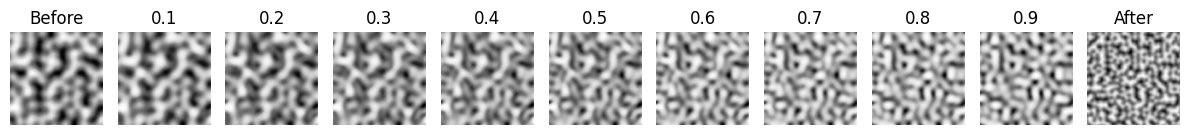

In [59]:
allstates2 = [A[0], *generated_states2, A[1]]
alltitles2 = ["Before", *timesteps, "After"]
print('epsilon:',eps2)
plt_image_row(allstates2, alltitles2)

In [60]:
plt_image_annimate(allstates2)
plt_image_annimate(generated_states2)

#### BELOW IS SCRAP

In [8]:
!pip install perlin-noise

Generating Perlin noise data...


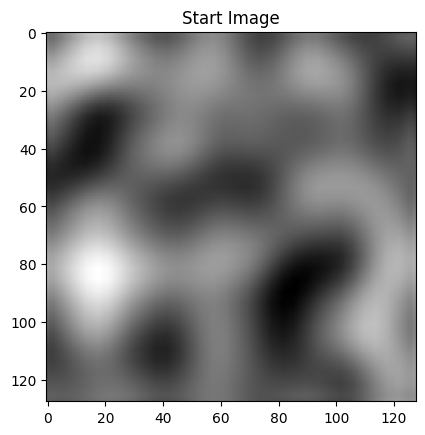

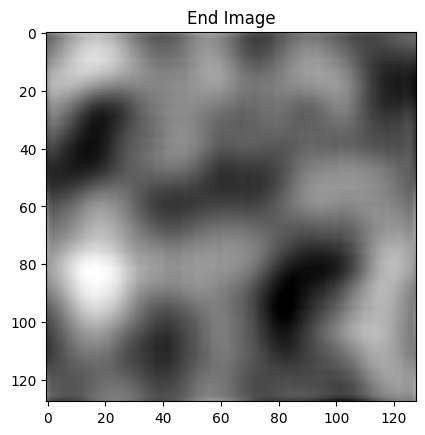

Generating animation frames using convolutional barycenters...


AssertionError: 

In [12]:
# ==============================================================================
# FINAL DEFINITIVE SCRIPT (v7): Using Convolutional Wasserstein Barycenters
# This implements the user's suggestion for the most efficient and correct method.
# ==============================================================================

# 1. INSTALL AND IMPORT LIBRARIES
# ------------------------------------------------------------------------------
!pip install -q pot
import numpy as np
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
from skimage.transform import resize
import ot


# 2. SETUP AND DATA GENERATION
# ------------------------------------------------------------------------------
# We can use larger dimensions because this method is much faster.
HR_DIMS = (128, 128)
LR_DIMS = (32, 32)

print("Generating Perlin noise data...")
# Generate two distinct Perlin noise patterns
noise_hr = PerlinNoise(octaves=6, seed=1)
hr_band = np.zeros(HR_DIMS)
for i in range(HR_DIMS[0]):
    for j in range(HR_DIMS[1]):
        hr_band[i][j] = noise_hr([i/HR_DIMS[0], j/HR_DIMS[1]])

noise_lr = PerlinNoise(octaves=4, seed=2)
lr_band = np.zeros(LR_DIMS)
for i in range(LR_DIMS[0]):
    for j in range(LR_DIMS[1]):
        lr_band[i][j] = noise_lr([i/LR_DIMS[0], j/LR_DIMS[1]])

# Normalize images to a 0-1 range
hr_band = (hr_band - np.min(hr_band)) / (np.max(hr_band) - np.min(hr_band))
lr_band = (lr_band - np.min(lr_band)) / (np.max(lr_band) - np.min(lr_band))


# 3. DEFINE START AND END STATES
# ------------------------------------------------------------------------------
# Start state is the upsampled low-resolution image
start_image = resize(lr_band, HR_DIMS, order=1)


# End state is a high-quality sharpened image
hr_detail = hr_band - resize(resize(hr_band, LR_DIMS), HR_DIMS, order=1)
end_image = np.clip(start_image + hr_detail, 0, 1)

plt.imshow(start_image, cmap='gray')
plt.title('Start Image')
plt.show()

plt.imshow(end_image, cmap='gray')
plt.title('End Image')
plt.show()

# --- Added normalization to make images sum to 1 ---
# This ensures they are probability distributions, a common requirement for OT
start_image_normalized = start_image / np.sum(start_image)
end_image_normalized = end_image / np.sum(end_image)

# The function requires a stack of images in a single array (n, n, n_images)
# Use the normalized images for the barycenter calculation
A = np.stack((start_image_normalized, end_image_normalized), axis=2)


# 4. COMPUTE THE INTERPOLATION USING CONVOLUTIONAL BARYCENTER
# ------------------------------------------------------------------------------
print("Generating animation frames using convolutional barycenters...")
# Epsilon (reg) is the regularization term.
# A smaller value is less blurry but can be less stable.
reg = 0.004
t_values = [0.0, 0.25, 0.5, 0.75, 1.0]
frames = []

for t in t_values:
    # Define the weights for the two images for the current timestep
    weights = np.array([1 - t, t])

    # --- Use the debiased convolutional barycenter function ---
    # This is the high-level, fast, and high-quality function for this job
    frame = ot.bregman.convolutional_barycenter2d_debiased(A, reg, weights=weights)
    frames.append(frame)

print("Done.")


# 5. VISUALIZE THE RESULT
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, len(t_values), figsize=(20, 4))
fig.suptitle('Continuous Interpolation via Debiased Convolutional Barycenters', fontsize=16)

for i, t in enumerate(t_values):
    axes[i].imshow(frames[i], cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()


# Debiased Sinkhorn barycenter demo

This example illustrates the computation of the debiased Sinkhorn barycenter
as proposed in [37]_.


.. [37] Janati, H., Cuturi, M., Gramfort, A. Proceedings of the 37th
        International Conference on Machine Learning, PMLR 119:4692-4701, 2020


In [2]:
!pip install pot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 24.7 MB/s eta 0:00:00


In [3]:
# Author: Hicham Janati <hicham.janati100@gmail.com>
#
# License: MIT License
# sphinx_gallery_thumbnail_number = 3

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import ot
from ot.bregman import (
    barycenter,
    barycenter_debiased,
    convolutional_barycenter2d,
    convolutional_barycenter2d_debiased,
)

## Debiased barycenter of 1D Gaussians



In [4]:
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=20, s=5)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=60, s=8)

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

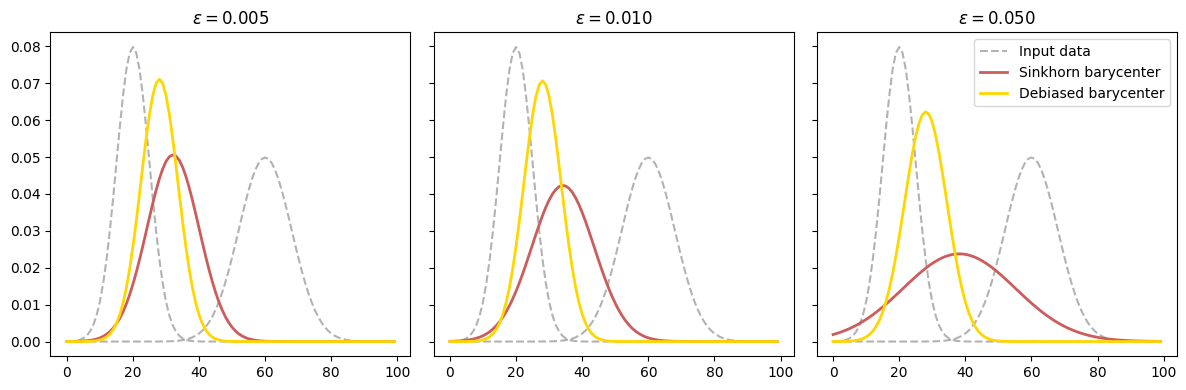

In [5]:
alpha = 0.2  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

epsilons = [5e-3, 1e-2, 5e-2]


bars = [barycenter(A, M, reg, weights) for reg in epsilons]
bars_debiased = [barycenter_debiased(A, M, reg, weights) for reg in epsilons]
labels = ["Sinkhorn barycenter", "Debiased barycenter"]
colors = ["indianred", "gold"]

f, axes = plt.subplots(
    1, len(epsilons), tight_layout=True, sharey=True, figsize=(12, 4), num=1
)
for ax, eps, bar, bar_debiased in zip(axes, epsilons, bars, bars_debiased):
    ax.plot(A[:, 0], color="k", ls="--", label="Input data", alpha=0.3)
    ax.plot(A[:, 1], color="k", ls="--", alpha=0.3)
    for data, label, color in zip([bar, bar_debiased], labels, colors):
        ax.plot(data, color=color, label=label, lw=2)
    ax.set_title(r"$\varepsilon = %.3f$" % eps)
plt.legend()
plt.show()

## Debiased barycenter of 2D images



In [21]:
this_file = os.path.realpath("__file__")
data_path = os.path.join(Path(this_file).parent.parent.parent, "data")
# f1 = 1 - plt.imread(os.path.join(data_path, "heart.png"))[:, :, 2]
# f2 = 1 - plt.imread(os.path.join(data_path, "duck.png"))[:, :, 2]

f1= noise - noise.min()
f2= noise2 - noise2.min()

A = np.asarray([f1, f2]) + 1e-2
A /= A.sum(axis=(1, 2))[:, None, None]

Display the input images



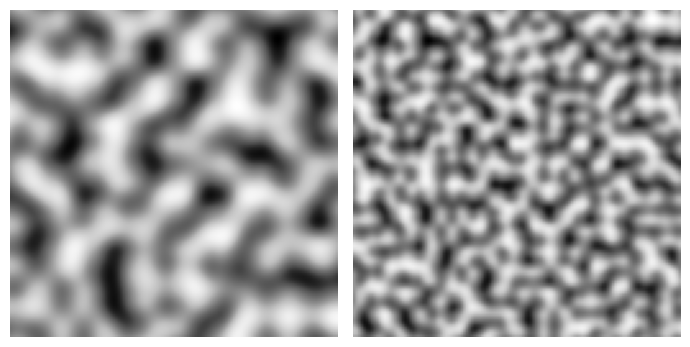

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4), num=2)
for ax, img in zip(axes, A):
    ax.imshow(img, cmap="Greys")
    ax.axis("off")
fig.tight_layout()
plt.show()

## Barycenter computation and visualization




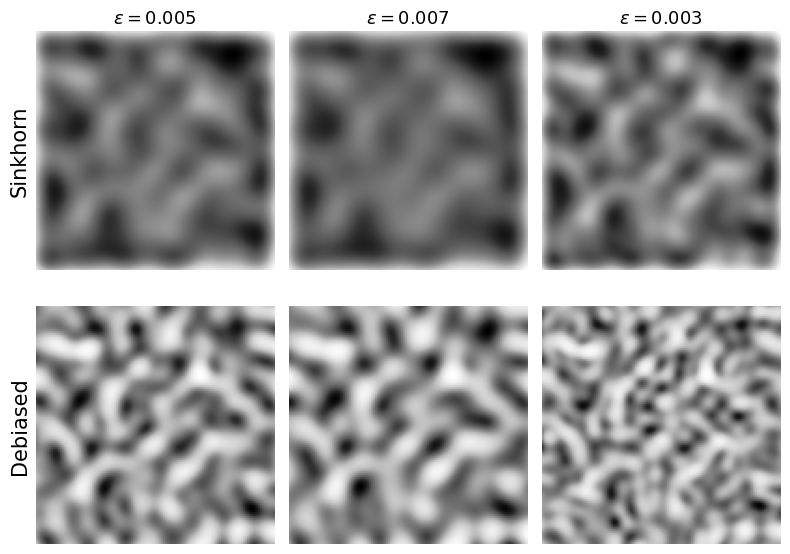

In [33]:
bars_sinkhorn, bars_debiased = [], []
epsilons = [5e-3, 7e-3, 3e-3]
for eps in epsilons:
    bar = convolutional_barycenter2d(A, eps)
    bar_debiased, log = convolutional_barycenter2d_debiased(A, eps, log=True)
    bars_sinkhorn.append(bar)
    bars_debiased.append(bar_debiased)

titles = ["Sinkhorn", "Debiased"]
all_bars = [bars_sinkhorn, bars_debiased]
fig, axes = plt.subplots(2, 3, figsize=(8, 6), num=3)
for jj, (method, ax_row, bars) in enumerate(zip(titles, axes, all_bars)):
    for ii, (ax, img, eps) in enumerate(zip(ax_row, bars, epsilons)):
        ax.imshow(img, cmap="Greys")
        if jj == 0:
            ax.set_title(r"$\varepsilon = %.3f$" % eps, fontsize=13)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        if ii == 0:
            ax.set_ylabel(method, fontsize=15)
fig.tight_layout()
plt.show()

In [34]:
# before, during, after figures
fig, axes = plt.subplots(1, 3, figsize=(12, 4), num=4)
for ax, img in zip(axes, [A[0], bars_debiased[2], A[1]]):
    ax.imshow(img, cmap="Greys")
    ax.axis("off")
fig.tight_layout()
plt.show()

Generating different states from your code...
Done.


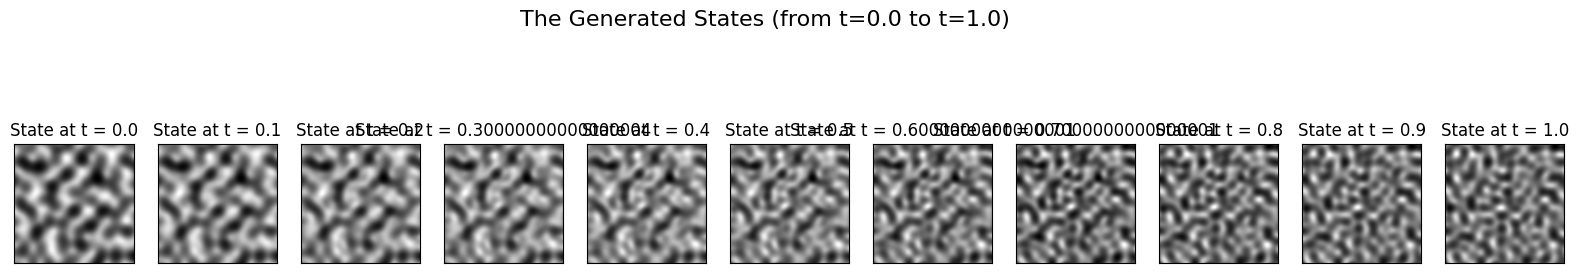

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import ot # Make sure ot is imported

# --- This part assumes you have already created these variables ---
# For example:
# A = np.stack((start_image, end_image), axis=2)
# ---

# Let's pick one value for epsilon for this demonstration
eps = 0.004

# The list of states you want to generate (e.g., 0%, 25%, 50%, 75%, 100%)
timesteps = [0.0, 0.25, 0.5, 0.75, 1.0]
timesteps = np.arange(0, 1.01, 0.1)

# A list to hold the generated images (the "states")
generated_states = []

print("Generating different states from your code...")
# Loop through the timesteps to generate each state
for t in timesteps:
    # 1. For each timestep 't', create the corresponding weights array.
    #    This is the key step.
    current_weights = np.array([1 - t, t])

    # 2. Call the function YOU provided, but now ADD the 'weights' parameter.
    #    We'll use the debiased version as it gives higher quality results.
    state, log = ot.bregman.convolutional_barycenter2d_debiased(A, eps, weights=current_weights, log=True)

    # 3. Add the resulting image to our list of states.
    generated_states.append(state)

print("Done.")

# 4. Now, let's plot the states you generated to prove they are different.
fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 4))
fig.suptitle('The Generated States (from t=0.0 to t=1.0)', fontsize=16)

for i, t in enumerate(timesteps):
    axes[i].imshow(generated_states[i], cmap='gray')
    axes[i].set_title(f'State at t = {t}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()

In [42]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

# --- This block assumes your list `frames` already exists ---

# 1. Set up the figure
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])

# 2. Create the image object that will be updated
im = ax.imshow(generated_states[0], cmap='gray')

# 3. Function to update the image for each frame
def update(i):
    im.set_data(generated_states[i])
    return [im]

# 4. Create and display the animation
anim = FuncAnimation(fig, update, frames=len(generated_states), interval=60)
plt.close() # Hide the static plot
HTML(anim.to_jshtml())

NameError: name 'start_image' is not defined

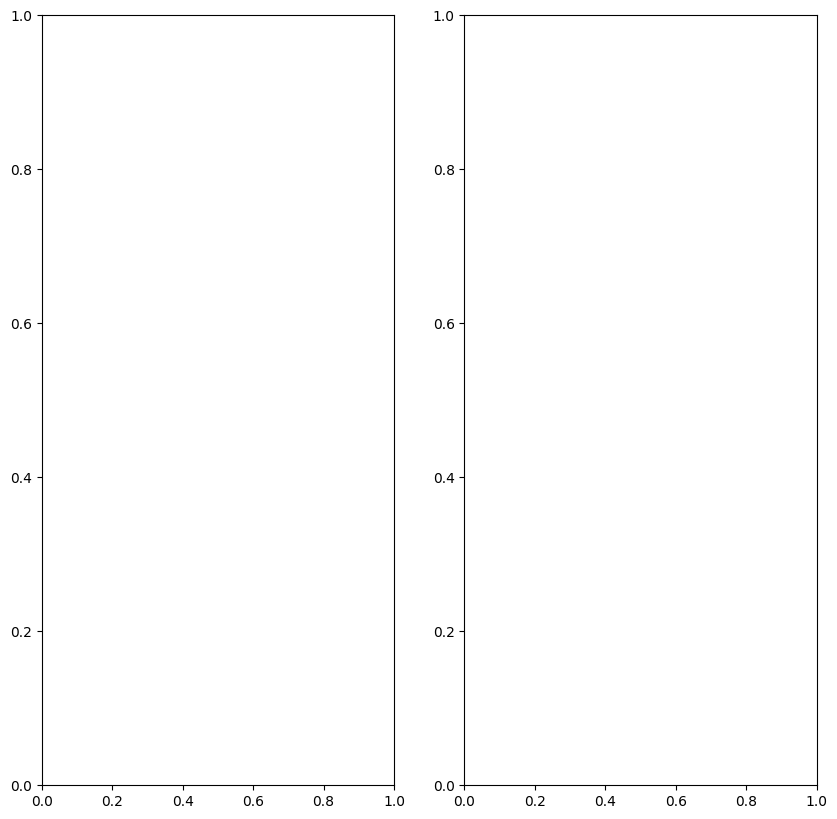

In [2]:
#now lets compare with simple interpolation
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(start_image, cmap='gray')
axes[0].set_title('Start Image')
axes[1].imshow(end_image, cmap='gray')
axes[1].set_title('End Image')
plt.show()